<a href="https://colab.research.google.com/github/pallavi-1311/image-stylization-opencv-vs-pil/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Screenshot 2025-04-01 203655.png to Screenshot 2025-04-01 203655 (3).png
Input image converted and saved as: Screenshot 2025-04-01 203655 (3)_input_processed.jpg

Select effects:
1 - Cartoonify
2 - Pencil Sketch
3 - Watercolor
4 - Comic Book
Enter effect numbers (comma-separated, e.g., 1,3): 1
cartoonify: Time = 0.0732s


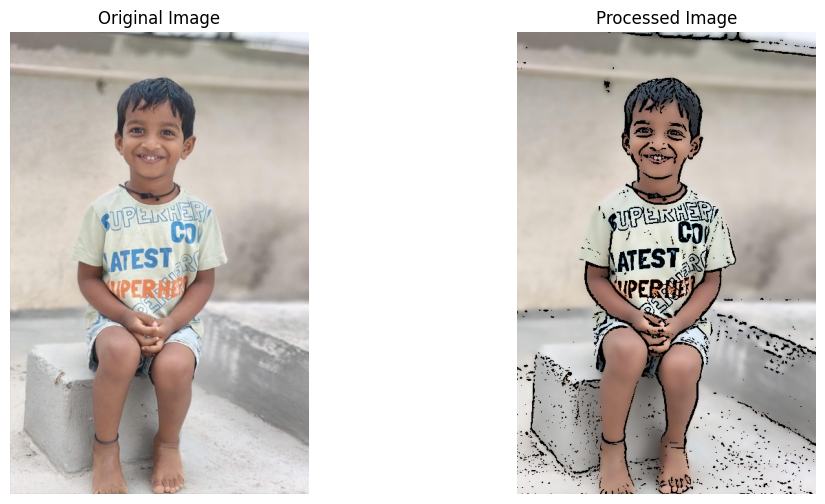

SSIM: 0.7747
MSE: 1328.0755
Standard Deviation: 35.1422
PSNR: 16.8986 dB


In [4]:
import numpy as np
import time
import os
import math
from skimage import filters, exposure, color
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from scipy.ndimage import median_filter, gaussian_filter, sobel
from skimage.metrics import structural_similarity as ssim
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
from google.colab import files
import cv2

# ------------------ Effect Functions ------------------

def measure_time(func, image):
    """Measure execution time of a function."""
    start_time = time.time()
    output = func(image.copy())  # Ensure each function gets an unmodified image
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"{func.__name__}: Time = {execution_time:.4f}s")

    return output

def cartoonify(image):
    """Improved cartoon effect using bilateral filter and edge detection."""
    image_cv = np.array(image.convert("RGB"))
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

    smooth_image = cv2.bilateralFilter(image_cv, d=9, sigmaColor=75, sigmaSpace=75)

    gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)

    cartoon_image = cv2.bitwise_and(smooth_image, smooth_image, mask=edges)

    cartoon_image = Image.fromarray(cv2.cvtColor(cartoon_image, cv2.COLOR_BGR2RGB))
    return cartoon_image

def pencil_sketch(image):
    """Improved pencil sketch using accurate blending."""
    image_cv = np.array(image.convert("RGB"))
    gray_image = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)

    inverted_image = 255 - gray_image
    blurred = cv2.GaussianBlur(inverted_image, (25, 25), 0)

    sketch = cv2.divide(gray_image, 255 - blurred, scale=256.0)

    sketch_image = Image.fromarray(sketch).convert("RGB")
    return sketch_image

def watercolor(image):
    """Apply a watercolor painting effect using edgePreservingFilter."""
    image_cv = np.array(image.convert("RGB"))
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

    result = cv2.edgePreservingFilter(image_cv, flags=1, sigma_s=60, sigma_r=0.4)

    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return Image.fromarray(result)

def comic_book(image):
    """Improved comic book style using posterization and edge overlay."""
    image = image.convert("RGB")
    img_np = np.array(image)

    # Edge Detection
    gray = np.dot(img_np[...,:3], [0.299, 0.587, 0.114])
    edge_x = sobel(gray, axis=0)
    edge_y = sobel(gray, axis=1)
    edges = np.hypot(edge_x, edge_y)
    edges = (edges / edges.max() * 255).astype(np.uint8)
    edges = Image.fromarray(edges).convert("L")
    edges = edges.point(lambda x: 0 if x < 50 else 255).convert("RGB")

    # Posterization
    posterized = image.convert("P", palette=Image.ADAPTIVE, colors=8).convert("RGB")
    posterized_np = np.array(posterized)

    # Combine
    cartoon_np = np.bitwise_and(posterized_np, np.array(edges))

    return Image.fromarray(cartoon_np)

def convert_input_to_jpeg(image, output_path):
    """Convert and save the input image as JPEG."""
    jpeg_path = os.path.splitext(output_path)[0] + "_input_processed.jpg"
    image = image.convert("RGB")
    image.save(jpeg_path, "JPEG", quality=95)
    print(f"Input image converted and saved as: {jpeg_path}")
    return jpeg_path

# ------------------ Main Code ------------------

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
image = Image.open(img_path)

if image is None:
    print("Error: Unable to load image. Check the file path.")
    exit()

image = ImageOps.exif_transpose(image)
jpeg_output_path = convert_input_to_jpeg(image, img_path)
image = Image.open(jpeg_output_path)

# Select Effects
print("\nSelect effects:")
print("1 - Cartoonify")
print("2 - Pencil Sketch")
print("3 - Watercolor")
print("4 - Comic Book")

choices = input("Enter effect numbers (comma-separated, e.g., 1,3): ")
choices = choices.split(",")

output = image.copy()
for choice in choices:
    effect = choice.strip()
    if effect == "1":
        output = measure_time(cartoonify, output)
    elif effect == "2":
        output = measure_time(pencil_sketch, output)
    elif effect == "3":
        output = measure_time(watercolor, output)
    elif effect == "4":
        output = measure_time(comic_book, output)
    else:
        print(f"Invalid choice: {effect}")

# Resize for display
max_width = 800
if image.width > max_width:
    scale_factor = max_width / image.width
    new_width = int(image.width * scale_factor)
    new_height = int(image.height * scale_factor)
    image = image.resize((new_width, new_height))
    output = output.resize((new_width, new_height))

# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(output)
axes[1].set_title("Processed Image")
axes[1].axis('off')
plt.show()

# Image quality metrics
image_np = np.array(image)
output_np = np.array(output)

image_gray = np.dot(image_np[..., :3], [0.2989, 0.5870, 0.1140])
output_gray = np.dot(output_np[..., :3], [0.2989, 0.5870, 0.1140])

ssim_value, _ = ssim(image_gray, output_gray, full=True, data_range=255)
print(f"SSIM: {ssim_value:.4f}")

mse = np.mean((image_gray - output_gray) ** 2)
std_dev = np.std(image_gray - output_gray)

psnr_value = 100 if mse == 0 else 20 * math.log10(255.0 / math.sqrt(mse))

print(f"MSE: {mse:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"PSNR: {psnr_value:.4f} dB")

Saving Screenshot 2025-04-01 203655.png to Screenshot 2025-04-01 203655 (5).png
Input image converted and saved as: Screenshot 2025-04-01 203655 (5)_processed.jpg

Select effects:
1 - Cartoonify
2 - Pencil Sketch
3 - Watercolor
4 - Comic Book
Enter effect numbers (comma-separated, e.g., 1,3): 4
comic_book: Time = 0.0086s


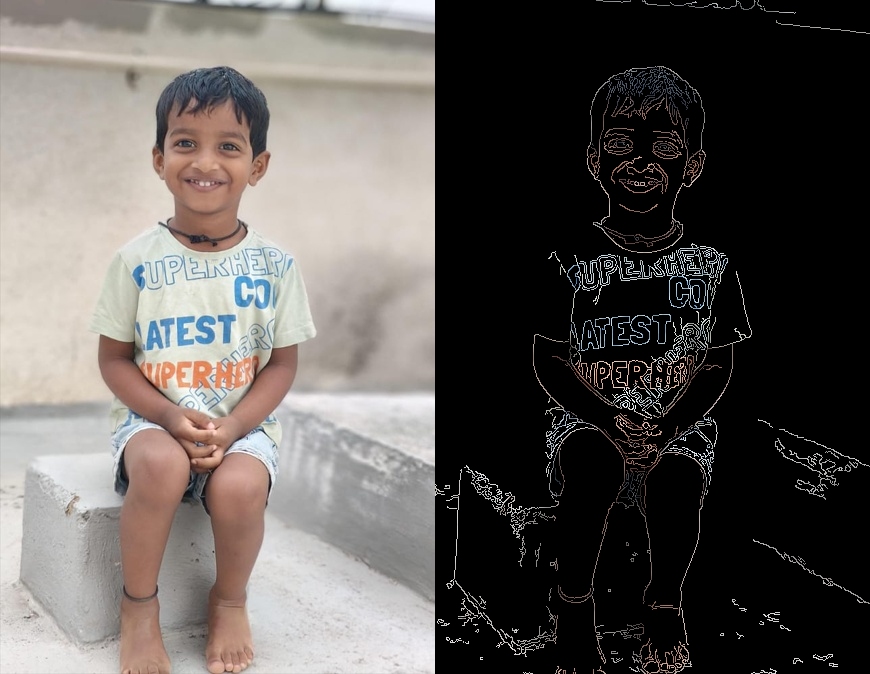

SSIM: 0.0044
MSE: 104.6393
Standard Deviation: 54.4849
PSNR: 27.9339 dB


In [6]:
import cv2
import numpy as np
import time
from skimage.metrics import structural_similarity as ssim
import math
import os
from google.colab import files
from google.colab.patches import cv2_imshow

def measure_time(func, image):
    """Measure execution time of a function."""
    start_time = time.time()
    output = func(image.copy())  # Ensure each function gets an unmodified image
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"{func.__name__}: Time = {execution_time:.4f}s")

    return output

def cartoonify(image):
    """Apply a cartoon effect."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.medianBlur(gray, 5)
    edges = cv2.adaptiveThreshold(gray_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9)
    color = cv2.bilateralFilter(image, 9, 250, 250)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    cartoon = cv2.bitwise_and(color, edges_colored)
    return cartoon

def pencil_sketch(image):
    """Convert the image to a pencil sketch."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inv_gray = 255 - gray
    blur = cv2.GaussianBlur(inv_gray, (21, 21), 0)
    sketch = cv2.divide(gray, 255 - blur, scale=256)
    return cv2.cvtColor(sketch, cv2.COLOR_GRAY2BGR)

def watercolor(image):
    """Apply a watercolor painting effect."""
    result = cv2.edgePreservingFilter(image, flags=1, sigma_s=60, sigma_r=0.4)
    return result

def comic_book(image):
    """Apply a comic book effect."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    comic = cv2.bitwise_and(image, edges_colored)
    return comic

def convert_input_to_jpeg(image, output_path):
    """Convert and save the input image as JPEG if needed."""
    ext = os.path.splitext(output_path)[-1].lower()
    if ext in ['.jpg', '.jpeg']:
        print("Image is already in JPEG format. Skipping conversion.")
        return output_path  # No conversion needed

    jpeg_path = os.path.splitext(output_path)[0] + "_processed.jpg"
    cv2.imwrite(jpeg_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    print(f"Input image converted and saved as: {jpeg_path}")
    return jpeg_path

# Dictionary of available filters
filters = {
    "1": cartoonify,
    "2": pencil_sketch,
    "3": watercolor,
    "4": comic_book,
}

# Upload image file from local system
uploaded = files.upload()

# Assuming the user uploaded a single image file, we take the first uploaded file
img_path = list(uploaded.keys())[0]
image = cv2.imread(img_path)

if image is None:
    print("Error: Unable to load image. Check the file format.")
    exit()

# Convert to JPEG if needed
jpeg_output_path = convert_input_to_jpeg(image, img_path)

# Reload the processed JPEG image for further processing
image = cv2.imread(jpeg_output_path)

# Show available effects
print("\nSelect effects:")
print("1 - Cartoonify")
print("2 - Pencil Sketch")
print("3 - Watercolor")
print("4 - Comic Book")

# Let the user choose multiple effects
choices = input("Enter effect numbers (comma-separated, e.g., 1,3): ")
choices = choices.split(",")

# Apply each selected effect one by one with time measurement
output = image.copy()
for choice in choices:
    effect = choice.strip()
    if effect in filters:
        output = measure_time(filters[effect], output)  # Apply effect & measure time
    else:
        print(f"Invalid choice: {effect}")

# Resize image if too large while maintaining aspect ratio
max_width = 800
if image.shape[1] > max_width:
    scale_factor = max_width / image.shape[1]
    image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
    output = cv2.resize(output, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

# Show original and processed images side by side
comparison = np.hstack((image, output))

# Display the comparison image in Google Colab
cv2_imshow(comparison)

# Compute SSIM, PSNR, MSE, and Standard Deviation
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
output_gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)

ssim_value, _ = ssim(image_gray, output_gray, full=True)
print(f"SSIM: {ssim_value:.4f}")

mse = np.mean((image_gray - output_gray) ** 2)
std_dev = np.std(image_gray - output_gray)

if mse == 0:
    psnr_value = 100
else:
    psnr_value = 20 * math.log10(255.0 / math.sqrt(mse))

print(f"MSE: {mse:.4f}")
print(f"Standard Deviation: {std_dev:.4f}")
print(f"PSNR: {psnr_value:.4f} dB")